Enter the path to your CSV file: /Users/aysekoksoy/Desktop/Local_TLS_App_TESTdata.csv
Enter the radius for TLS detection in microns (e.g., 160): 160


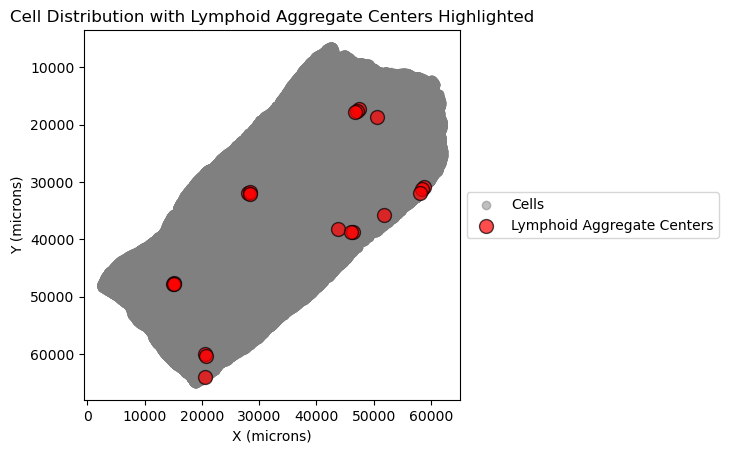

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
import networkx as nx
import matplotlib.pyplot as plt

def measure_TLS(df, radius):
    """
    Classify clusters of cells into TLS categories.
    
    :param df: DataFrame with columns ['X', 'Y', 'Phenotype']
    :param radius: Radius to consider for neighborhood
    :return: DataFrame with TLS classification and centers
    """
    # Create KDTree for spatial querying
    tree = KDTree(df[['X', 'Y']].values)

    # Network for cluster analysis
    G = nx.Graph()

    # Add nodes
    for idx, row in df.iterrows():
        G.add_node(idx, phenotype=row['Phenotype'], x=row['X'], y=row['Y'])

    # Add edges based on spatial proximity
    for idx in G.nodes:
        neighbors = tree.query_ball_point(df.loc[idx, ['X', 'Y']], r=radius)
        for neighbor in neighbors:
            if neighbor != idx:
                G.add_edge(idx, neighbor)
    
    used_cells = set()

    # Initialize lists to store classification results and aggregate centers
    tls_classifications = []
    aggregate_centers = []
    aggregate_coordinates = []

    # Iterate over B and T cells
    for idx, row in df.iterrows():
        if row['Phenotype'] in ['CD20', 'CD3'] and idx not in used_cells:
            # Find neighboring cells
            neighbors = tree.query_ball_point([row['X'], row['Y']], r=radius)
            neighbor_phenotypes = df.iloc[neighbors]['Phenotype']

            # Count B and T cells, excluding used cells
            bt_cell_count = sum(1 for i in neighbors if i not in used_cells and df.at[i, 'Phenotype'] in ['CD20', 'CD3'])

            # Classification logic
            if bt_cell_count >= 50:
                classification = 'Lymphoid Aggregate'
                tls_classifications.append(classification)
                aggregate_centers.append(idx)
                aggregate_coordinates.append((row['X'], row['Y']))  # Append the coordinates

                # Mark all cells in this aggregate as used
                used_cells.update(neighbors)

    # Create a DataFrame for the results
    results_df = pd.DataFrame({
        'Aggregate_Center_Index': aggregate_centers,
        'Aggregate_Center_Coordinates': aggregate_coordinates,
        'Classification': tls_classifications
    })

    return results_df

def plot_tls_results(df, tls_results):
    fig, ax = plt.subplots()
    ax.scatter(df['X'], df['Y'], color='gray', label='Cells', alpha=0.5)
    ax.invert_yaxis()
    ax.set_aspect('equal')

    # Extract aggregate centers for plotting
    aggregate_centers = tls_results['Aggregate_Center_Coordinates'].tolist()
    aggregate_x = [coord[0] for coord in aggregate_centers]
    aggregate_y = [coord[1] for coord in aggregate_centers]

    ax.scatter(aggregate_x, aggregate_y, color='red', label='Lymphoid Aggregate Centers', s=100, edgecolor='black', alpha=0.7)
    ax.set_xlabel('X (microns)')
    ax.set_ylabel('Y (microns)')
    ax.set_title('Cell Distribution with Lymphoid Aggregate Centers Highlighted')
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

# Main script to run locally
if __name__ == '__main__':
    # Prompt for the CSV file path and radius
    file_path = input("Enter the path to your CSV file: ")
    radius = float(input("Enter the radius for TLS detection in microns (e.g., 160): "))
    
    # Load the CSV file
    df = pd.read_csv(file_path)

    # Run the TLS measurement function
    tls_results = measure_TLS(df, radius)

    # Plot the results
    plot_tls_results(df, tls_results)
